In [19]:
import sys
sys.path.append('..')

import torch
from data.dataset import Dataset_FFN
from src.evaluate import BLEU_eval
from src.train import evaluate
from src.models.model import Model
from src.pickle_loader import PickleLoader
from src.data_loader import DataLoader as Custom_DL
from torch.utils.data import DataLoader
from datetime import datetime

from src.utils.metrics import Metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import subprocess

from src.search.scoring import score_corpus

/Users/lukas/anaconda3/envs/MT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
metric = Metrics()
translation_loader = Custom_DL('../results/7k_BPE_indexed/hyp.txt')
reference_loader = Custom_DL('../data/unpreprocessed/dev/target.dev')
print(translation_loader.tokenize(mode='lines'))
print(reference_loader.tokenize(mode='lines'))
metric.bleu_score(4,translation_loader.tokenize(mode='lines'), reference_loader.tokenize(mode='lines'))

['a group of friends are working on a hill .', 'man sleeping in a green room on a couch .', 'boy wearing headphones sitting on the shoulders of a woman .', 'men are sharing a small group of people are standing in the lake .', 'man with a hat standing in the middle of a red cowboy hat is sitting in a small boat .', 'woman in a red coat walking down the street .', 'brown dog is running across the dog .', 'little boy with an olive section in an attempt to hit a ball in a city square .', 'man in a beard .', 'smiling woman with a pink fork .', 'young child stands alone on a surfboard .', 'person on a snowbank of a jungle gym in the air .', 'young children are standing around a red dumpster .', 'woman sits in her seats .', 'woman playing a violin on her head .', 'people on two side of a building in the woods .', 'a naked man asleep in a chair .', 'a group of people are standing in front of a parking lot .', 'young woman in the woods .', 'girls , one of a group of people are standing in a cro

0.20921031502198517

In [14]:
# defines
MAX_DECODING_TIME_STEP = 100
MODEL_PATH = "../logs/baba_model_3/checkpoints/model_7.pt"

In [16]:
# load model
model = torch.load(MODEL_PATH)
model_config = model.config

bpe_ops = model_config['bpe_ops']
joined_bpe = model_config['joined_bpe']

In [20]:

bleu = []
model_path = f"../logs/baba_model_3/checkpoints/model_5.pt"
model = torch.load(model_path)
bleu += [BLEU_eval(model=model,bleu_n=4,dev_source='../data/unpreprocessed/dev/source.dev',dev_target='../data/unpreprocessed/dev/target.dev',bpe_ops=bpe_ops,joined_bpe=joined_bpe,alignment_modeling='average',beam_size=20,max_decoding_time_step=MAX_DECODING_TIME_STEP)]


In [17]:
print(BLEU_eval(model=model,bleu_n=4,dev_source='../data/unpreprocessed/dev/source.dev',dev_target='../data/unpreprocessed/dev/target.dev',bpe_ops=bpe_ops,joined_bpe=joined_bpe,alignment_modeling='average',beam_size=20,max_decoding_time_step=MAX_DECODING_TIME_STEP))

0.21278952937305942


# Checkpoint Evaluation for Best Model


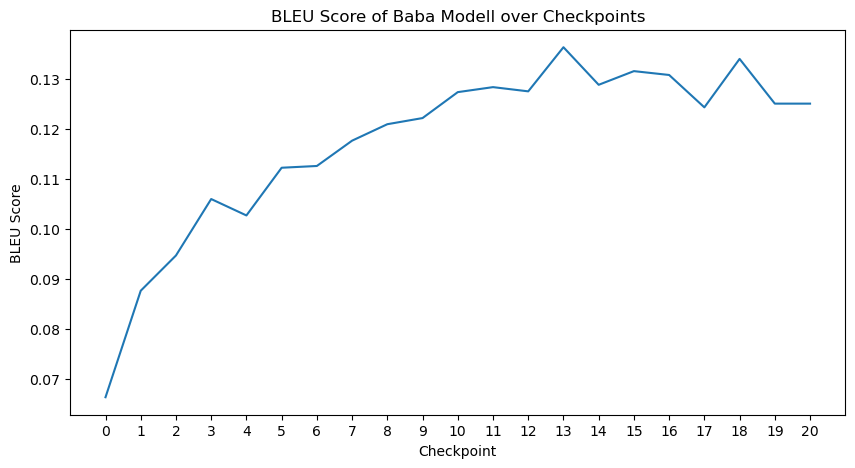

In [18]:
results_path = "../results/v4/baba_model_checkpoint_BLEUs.pickle"
results = PickleLoader.load(results_path)

BLEUs_ordered = []

for i in range(21):
    model_name = f"model_{i}.pt"
    BLEUs_ordered.append(results[model_name])

plt.figure(figsize=(10, 5)) 
plt.plot(range(21), BLEUs_ordered)
plt.xlabel('Checkpoint')
plt.ylabel('BLEU Score')
plt.title('BLEU Score of Baba Modell over Checkpoints')
plt.xticks(range(21))
plt.show()

# Testing Beam Sizes on Two Models


In [21]:
# load data
dev_source_indexed = model_config['dev_source']
dev_target_indexed = model_config['dev_target']

dev_target_text_path = "../data/unpreprocessed/dev/target.dev"
dev_source_text_path = "../data/unpreprocessed/dev/source.dev"

# load BPE and dictionary
bpe_path = f"../encoder/BPE_{'JOINED' if joined_bpe else 'EN'}_{bpe_ops}.pickle"
target_bpe = PickleLoader.load(bpe_path)

dictionary_path = f"../dictionaries/dict_{'JOINED_' if joined_bpe else ''}EN_{bpe_ops}.pkl"
target_dictionary = PickleLoader.load(dictionary_path)

In [22]:
BLEUs = []

progress_bar = tqdm(range(1, 51), desc="Testing Beam sizes...")
for beam_size in progress_bar:
    #print(f"Testing beam size {beam_size}...")
    BLEUs.append(BLEU_eval(model=model, bleu_n=4, dev_source=dev_source_text_path, dev_target=dev_target_text_path,
                           beam_size=beam_size, max_decoding_time_step=MAX_DECODING_TIME_STEP, bpe_ops=bpe_ops,
                           joined_bpe=joined_bpe, alignment_modeling="average"))
    
    # progress_bar.set_postfix(f"Last BLEU: {BLEUs[-1]} (with beamsize {beam_size})")
    postfix_str = {"Last BLEU": BLEUs[-1], "Best BLEU": max(BLEUs), "Best BLEU Beam Size": BLEUs.index(max(BLEUs)) + 1}
    progress_bar.set_postfix(postfix_str)

TIME = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

Testing Beam sizes...:   0%|          | 0/50 [00:07<?, ?it/s]


KeyboardInterrupt: 

In [ ]:

PickleLoader.save(f"../results/v4/beam_search_results_1k_Joined_BPE_{TIME}.pkl", BLEUs)

In [16]:
plt.plot(range(1, 51), BLEUs)
plt.xlabel("Beam Size")
plt.ylabel("BLEU")
plt.title("BLEU Score depending on Beam Size")
plt.savefig(f"../results/v4/beam_search_results_1K_JOINED_BPE_{TIME}.png")
plt.show()

NameError: name 'BLEUs' is not defined

In [ ]:
progress_bar = tqdm(range(1, 51), desc="Testing Beam sizes...")
for beam_size in progress_bar:
    #print(f"Testing beam size {beam_size}...")
    BLEU_eval(model=model, bleu_n=4, dev_source=dev_source_text_path, dev_target=dev_target_text_path,
                           beam_size=beam_size, max_decoding_time_step=MAX_DECODING_TIME_STEP,
                           alignment_modeling="average")
    
    # progress_bar.set_postfix(f"Last BLEU: {BLEUs[-1]} (with beamsize {beam_size})")
    #progress_bar.set_postfix(postfix_str)

TIME = datetime.now().strftime("%Y-%m-%d_%H-%M-% gitS")

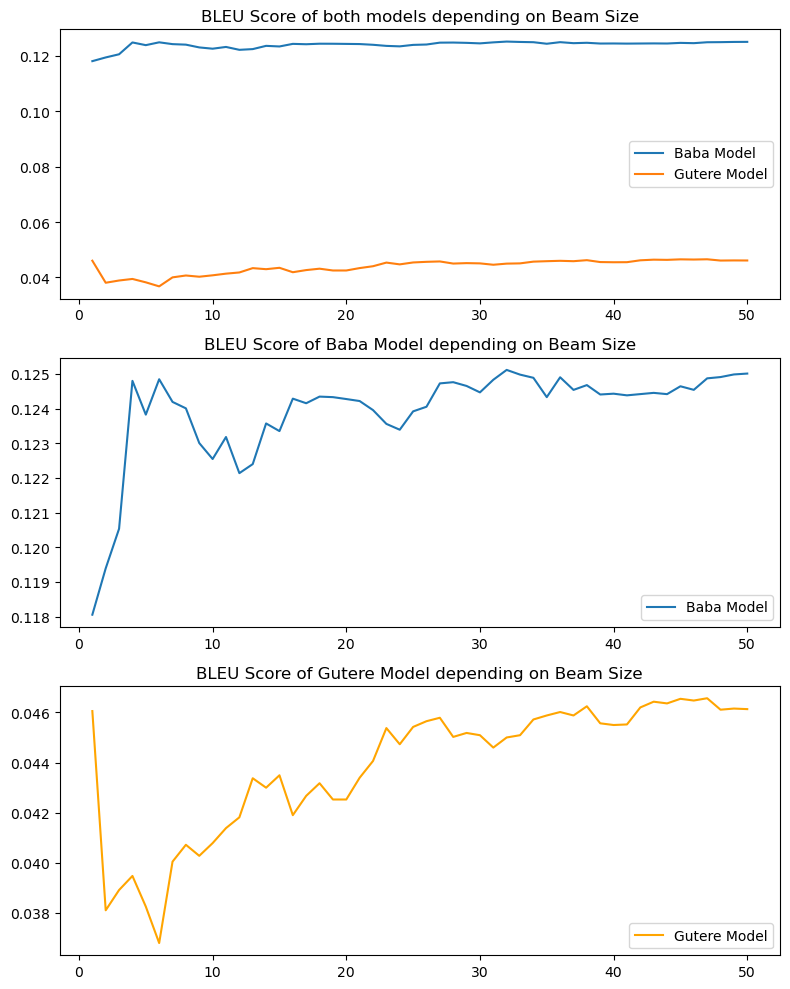

In [23]:
results_baba_model = PickleLoader.load("../results/v4/beam_size_comparision/beam_size_comparision_baba_modell.pkl")
results_gutere_model = PickleLoader.load("../results/v4/beam_size_comparision/beam_size_comparision_gutere_modell.pkl")

# Create the figure and subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))

CHECKPOINTS = range(1, 51)

# Plotting on the first subplot
axes[0].plot(CHECKPOINTS, results_baba_model, label="Baba Model")
axes[0].plot(CHECKPOINTS, results_gutere_model, label="Gutere Model")
axes[0].set_title('BLEU Score of both models depending on Beam Size')
axes[0].legend()

# Plotting on the second subplot
axes[1].plot(CHECKPOINTS, results_baba_model, label="Baba Model")
axes[1].set_title('BLEU Score of Baba Model depending on Beam Size')
axes[1].legend()

# Plotting on the third subplot
axes[2].plot(CHECKPOINTS, results_gutere_model, label="Gutere Model", color="orange")
axes[2].set_title('BLEU Score of Gutere Model depending on Beam Size')
axes[2].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

# Scoring of reference and Baba Model translation of dev set

In [20]:
model = torch.load("../logs/baba_modell/checkpoints/model_20.pt")
model_config = model.config

#load data
alignment = model_config['batch_alignment']
#dev_set
dev_target_indexed_path = "../data/1k_joined_BPE_indexed/dev/target.dev.pickle"
dev_source_indexed_path = "../data/1k_joined_BPE_indexed/dev/source.dev.pickle"

#reference
decoded_list = []

decoded_reference = "../data/unpreprocessed/dev/target.dev"

decoded_raw_path1 = "../results/v4/decodings/baba_model_decodings/dev_decoding_baba_modell_1_best.txt"
decoded_raw_path2 = "../results/v4/decodings/baba_model_decodings/dev_decoding_baba_modell_2_best.txt"
decoded_raw_path3 = "../results/v4/decodings/baba_model_decodings/dev_decoding_baba_modell_3_best.txt"
decoded_raw_path10 = "../results/v4/decodings/baba_model_decodings/dev_decoding_baba_modell_10_best.txt"
decoded_raw_path20 = "../results/v4/decodings/baba_model_decodings/dev_decoding_baba_modell_20_best.txt"
decoded_raw_path30 = "../results/v4/decodings/baba_model_decodings/dev_decoding_baba_modell_30_best.txt"

"""
decodings = {
    'reference': decoded_reference,
    'best_1': decoded_raw_path1,
    'best_2': decoded_raw_path2,
    'best_3': decoded_raw_path3,
    'best_10': decoded_raw_path10,
    'best_20': decoded_raw_path20,
    'best_30': decoded_raw_path30
}
"""

decodings = {
    'reference': decoded_reference,
    'best_1': decoded_raw_path1
}

# get encoder and dictionary
ENCODER_PATH = "../encoder/BPE_JOINED_1000.pickle"
encoder = PickleLoader.load(ENCODER_PATH)
DICTIONARY_PATH = "../dictionaries/dict_JOINED_EN_1000.pkl"
dictionary = PickleLoader.load(DICTIONARY_PATH)



In [22]:
scores = {}
for decoding_id, decoding_path in decodings.items():
    dataloader = Custom_DL(decoding_path)
    decoded_encoded = encoder.encode_corpus(dataloader.load_data())
    decoded_indexed = dictionary.apply_mapping(decoded_encoded)

    PickleLoader.save('____tmp.pkl', decoded_indexed)
    score = score_corpus(source_path=dev_source_indexed_path, target_path='____tmp.pkl', model=model, alignment = model.config['batch_alignment'])

    scores[decoding_id] = score
    
    subprocess.run(['rm', '____tmp.pkl'])


Creating batches: 100%|██████████| 1015/1015 [00:00<00:00, 3361.17it/s, Batch=13792/13793, Row=1/1]


In [23]:
# plot the scores of the different decodings as a points
plt.figure(figsize=(10, 5))
for decoding_id, score in scores.items():
    plt.plot(score, label=decoding_id)
    print(score)
plt.xlabel('Decoding')
plt.ylabel('Score')
plt.title('Score of different decodings')
plt.legend()
plt.show()

[-38.80734400590882, -7.925443743077267, -21.226179005556332, -77.22560942173004, -56.40878714620021, -152.11021470365813, -7.414967854348106, -70.37158187785099, -69.00486482679844, -64.40639193356037, -35.778182376363475, -21.90425093534941, -15.409985166683327, -40.145522261358565, -27.420645061833056, -63.59425393535571, -28.104611564485822, -20.92094714079576, -49.24358111619949, -64.69900706303451, -59.019119721597235, -60.8264811789104, -44.3313511384531, -45.43459990618976, -26.376570369655383, -48.93337110219545, -16.42772939491624, -12.137950955235283, -7.2262788161679055, -74.98072314438468, -21.335114381625317, -66.55248919679434, -23.758291759058693, -108.15543707941833, -26.24403836813508, -8.741050188753434, -30.749402633635327, -30.088313418076723, -26.42948329896899, -63.399948860929726, -33.038111712550744, -51.86013200052548, -51.48863404104486, -37.42005989736572, -47.45805320729414, -108.92552530296962, -32.204051548746065, -40.48708899971098, -55.317398806102574, 

KeyboardInterrupt: 

Wir sehen, dass der Score für die automatische Übersetzung meistens deutlich höher ist als der Score für die Referenz. Das war aber offenkundig, da das Modell für die Übersetzungen natürlich auch indirekt die Scores verwendet.

# Evaluating BLEU and PPLs of different random seeds with Baba Modell

In [ ]:
BLEU_res = []
perplexity_res= []
num_checkpoints = 6

source_paths = ["../logs/random_seed_1/checkpoints/","../logs/random_seed_2/checkpoints/","../logs/random_seed_3/checkpoints/"]

for source_path in source_paths:
        model = torch.load(source_path+"model_0_3272.pt")
        model_config = model.config
        #TODO calc num_checkpoints with given path

        # get devset
        dev_source_indexed = model_config['dev_source']
        dev_target_indexed = model_config['dev_target']

        dev_target_raw = "../data/unpreprocessed/dev/target.dev"
        dev_source_raw = "../data/unpreprocessed/dev/source.dev"

        validation_dataset = Dataset_FFN(
                dev_source_indexed  , 
                dev_target_indexed, 
                bpe_ops = model_config['bpe_ops'], 
                joined_bpe=model_config['joined_bpe'],
                window_size=model_config['window_size'],
                batch_alignment=model_config['batch_alignment'],
                )

        validation_loader = DataLoader(validation_dataset, batch_size=model_config['batch_size'], shuffle=False)

        # calc BLEU and perplexity for every checkpoint
        BLEU_scores = []
        perplexity_scores =[]

        dev_source_data = Custom_DL(dev_source_raw)
        dev_target_data = Custom_DL(dev_target_raw)

        progress_bar = tqdm(range(1,num_checkpoints), desc='Enumerating over checkpoints')
        for i in progress_bar:
                model_path = source_path+f"model_{i}_3272.pt"
                model = torch.load(model_path)
                config = model.config
                
                BLEU_scores.append(BLEU_eval(model=model, bleu_n=4,dev_source=dev_source_raw, dev_target=dev_target_raw,
                                             max_decoding_time_step=10000, bpe_ops=config['bpe_ops'], joined_bpe=config['joined_bpe'],
                                             beam_size=10,alignment_modeling="average"))
                
                perplexity_scores.append(evaluate(model=model, validation_loader=validation_loader, epoch=i)[1])
        
        BLEU_res.append(BLEU_scores)
        perplexity_res.append(perplexity_scores)

In [ ]:
# Plot BLEU

plt.figure(figsize=(10, 5))
for i in range(len(source_paths)):
    plt.plot(range(1,num_checkpoints), BLEU_res[i], label=f"Random Seed {i}")
plt.xlabel('Checkpoint')
plt.ylabel('BLEU Score')
plt.legend()
plt.show()


# Plot perplexity
plt.figure(figsize=(10, 5))
for i in range(len(source_paths)):
    plt.plot(range(1,num_checkpoints), perplexity_res[i], label=f"Random Seed {i}")
plt.xlabel('Checkpoint')
plt.ylabel('BLEU Score')
plt.legend()
plt.show()

<img src="../results/v4/BLEU_randomseed.png"/>

<img src="../results/v4/perplexity_randomseed.png"/>